#Ispitivanje TabPFN-a na nepoznatim podacima
Sada ćemo analizirati kako se TabPFN ponaša ukoliko mu proslijedimo podatke koji su nepoznati. Koristiti ćemo sintetičke podatke generisane za svrhu klasifikacije.


 Klasifikacijom želimo predvidjeti da li će kosnik preći na premium paket na osnovu njegovih karakteristika i ponašanja (broj sesija, trajanje korištenja, starost, region, itd.)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

# Generisanje 500 lažnih korisnika
n_samples = 1500
df_synthetic = pd.DataFrame({
    'age': np.random.randint(16, 60, n_samples),
    'device_type': np.random.choice(['Android', 'iOS', 'Other'], n_samples),
    'session_count': np.random.poisson(lam=15, size=n_samples),
    'avg_session_time': np.random.normal(loc=5, scale=2, size=n_samples).clip(1, 15),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n_samples),
})

# Dodavanje ciljne varijable na osnovu ponašanja
def calculate_premium_prob(session_count, avg_time):
    return min(0.05 * session_count + 0.03 * avg_time, 0.9)

probs = [calculate_premium_prob(s, t) for s, t in zip(df_synthetic['session_count'], df_synthetic['avg_session_time'])]
df_synthetic['is_premium'] = np.random.binomial(1, probs)

for col in ['device_type', 'region']:
    df_synthetic[col] = LabelEncoder().fit_transform(df_synthetic[col])


X = df_synthetic.drop(columns=['is_premium']).to_numpy().astype('float32')
y = df_synthetic['is_premium'].to_numpy().astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Broj uzoraka po klasi:
is_premium
1    1247
0     253
Name: count, dtype: int64

Procenat po klasi:
is_premium
1    83.13
0    16.87
Name: proportion, dtype: float64


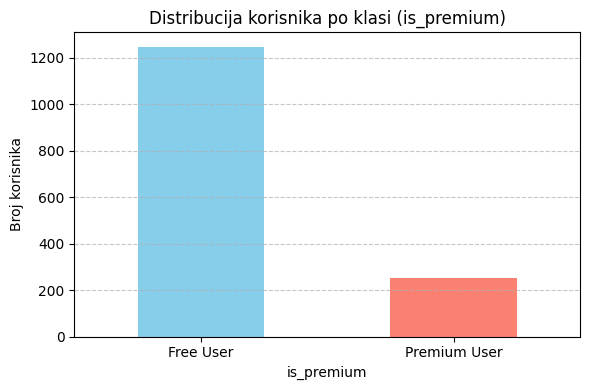

In [ ]:
import matplotlib.pyplot as plt

# Broj uzoraka po klasi
class_counts = df_synthetic['is_premium'].value_counts()
class_percent = df_synthetic['is_premium'].value_counts(normalize=True) * 100

print("Broj uzoraka po klasi:")
print(class_counts)

print("\nProcenat po klasi:")
print(class_percent.round(2))


plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Free User', 'Premium User'], rotation=0)
plt.ylabel("Broj korisnika")
plt.title("Distribucija korisnika po klasi (is_premium)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
!pip install tabpfn torch --quiet

In [ ]:
import torch
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, classification_report

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Koristi se uređaj: {device}")

model = TabPFNClassifier(device=device)
model.fit(X_train, y_train)

# Predikcija i evaluacija
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTačnost modela (1500 uzoraka): {accuracy:.4f}")
print("\nKlasifikacioni izvještaj:\n")
print(classification_report(y_test, y_pred, target_names=['Premium User', 'Free User']))


Koristi se uređaj: cuda

Tačnost modela (1500 uzoraka): 0.8333

Klasifikacioni izvještaj:

              precision    recall  f1-score   support

Premium User       0.67      0.04      0.07        51
   Free User       0.84      1.00      0.91       249

    accuracy                           0.83       300
   macro avg       0.75      0.52      0.49       300
weighted avg       0.81      0.83      0.77       300

